# **Milestone 3: Model Training and Evaluation**

# Import Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv('/kaggle/input/healthcare-dataset/healthcare_dataset.csv')
df.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


# From Previous Milestones

In [3]:
# DATA PROCESSING
# Convert dates and calculate length of stay
df['Date of Admission'] = pd.to_datetime(df['Date of Admission'], errors='coerce')
df['Discharge Date'] = pd.to_datetime(df['Discharge Date'], errors='coerce')
df['Length of Stay'] = (df['Discharge Date'] - df['Date of Admission']).dt.days

In [4]:
# Drop unnecessary columns
df.drop(['Name', 'Doctor', 'Hospital', 'Room Number'], axis=1, inplace=True, errors='ignore')

In [5]:
# FEATURE ENGINEERIN
# Convert gender to numerical (must do this before pipeline)
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})

# Create target variable (Risk)
df['Risk'] = (
    (df['Test Results'] == 'Abnormal') |
    (df['Age'] > 65) |
    (df['Medical Condition'].isin(['Diabetes', 'Hypertension', 'Asthma']))
).astype(int)

# Data Splitting

In [6]:
# Separate features and target
X = df.drop(['Test Results', 'Risk', 'Date of Admission', 'Discharge Date'], axis=1)
y = df['Risk']

In [7]:
# Check class balance
print("Class distribution:\n", y.value_counts())

Class distribution:
 Risk
1    42489
0    13011
Name: count, dtype: int64


In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

In [9]:
# PREPROCESSING PIPELINE
# Identify column types
numeric_features = ['Age', 'Billing Amount', 'Length of Stay', 'Gender']
categorical_features = ['Blood Type', 'Medical Condition', 'Admission Type', 'Insurance Provider', 'Medication']

# Create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Model Selection and Training

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Create Random Forest pipeline with preprocessing
rf_pipe = make_pipeline(
    preprocessor,
    RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=10,
        random_state=42
    )
)

In [11]:
# Train model
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Billing Amount',
                                                   'Length of Stay',
                                                   'Gender']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Blood Type',
                                                   'Medical Condition',
                                                   'Admission Type',
                                                   'Insurance Provider',
                                                   'Medication'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=10, min_samples_split=10,
                                        n_estimators=200, random_state=42))])

# Model Evaluation

In [12]:
# Training predictions and metrics
train_pred = rf_pipe.predict(X_train)
train_acc = rf_pipe.score(X_train, y_train)
train_precision = precision_score(y_train, train_pred, average='weighted')
train_recall = recall_score(y_train, train_pred, average='weighted')
train_f1 = f1_score(y_train, train_pred, average='weighted')

print("\nRandom Forest - Training Metrics:")
print(f"Accuracy: {train_acc:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")


Random Forest - Training Metrics:
Accuracy: 0.8810
Precision: 0.9211
Recall: 0.8810
F1 Score: 0.8880


In [13]:
# Test predictions and metrics
test_pred = rf_pipe.predict(X_test)
test_acc = rf_pipe.score(X_test, y_test)
test_precision = precision_score(y_test, test_pred, average='weighted')
test_recall = recall_score(y_test, test_pred, average='weighted')
test_f1 = f1_score(y_test, test_pred, average='weighted')

print("\nRandom Forest - Test Metrics:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")


Random Forest - Test Metrics:
Accuracy: 0.8758
Precision: 0.9188
Recall: 0.8758
F1 Score: 0.8833


In [14]:
# #classification report
print("\nDetailed Test Classification Report:")
# print(classification_report(y_test, test_pred))
print(classification_report(y_test, test_pred, target_names=["Low Risk", "High Risk"]))


Detailed Test Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.65      1.00      0.79      2602
   High Risk       1.00      0.84      0.91      8498

    accuracy                           0.88     11100
   macro avg       0.83      0.92      0.85     11100
weighted avg       0.92      0.88      0.88     11100



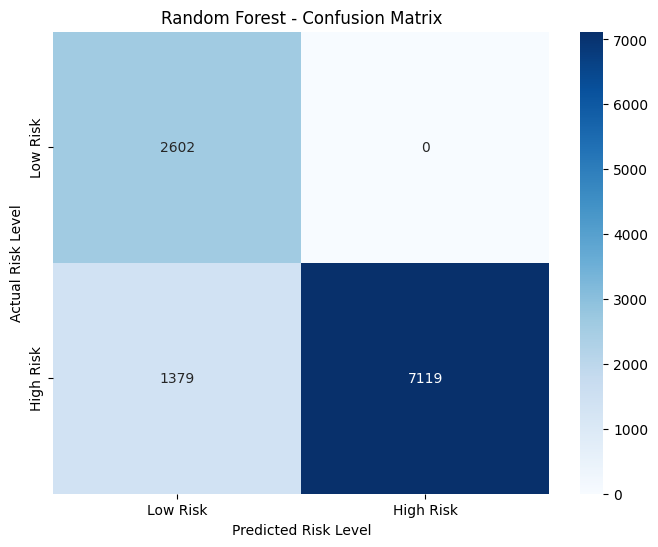

In [19]:
# Confusion matrix
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low Risk', 'High Risk'],
            yticklabels=['Low Risk', 'High Risk'])
plt.xlabel('Predicted Risk Level')
plt.ylabel('Actual Risk Level')
plt.title('Random Forest - Confusion Matrix')
plt.show()